[View in Colaboratory](https://colab.research.google.com/github/daphnei/weakvideo/blob/master/visualize_faces.ipynb)

In [1]:
#@title Run this to clone the code repo.
! git clone https://github.com/daphnei/weakvideo.git


fatal: destination path 'weakvideo' already exists and is not an empty directory.


In [34]:
#@title Run this to pull from the code repo if its already been cloned.
! cd weakvideo; git pull

remote: Counting objects: 4, done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/daphnei/weakvideo
   1d05e1c..0b8630c  master     -> origin/master
Updating 1d05e1c..0b8630c
Fast-forward
 code/cluster_all.py | 5 +++--
 1 file changed, 3 insertions(+), 2 deletions(-)


In [3]:
#@title Python imports

!pip install editdistance

import sys
import os
import numpy as np
import scipy
import scipy.ndimage
import skimage.color
import random
from collections import namedtuple

sys.path.append(os.path.abspath(os.path.join('weakvideo/code')))

import utils
import visualization as vis
import cluster_all

In [4]:
#@title Loads in data from nlpgrid.

# Need to update the paths in here too:
!wget www.seas.upenn.edu/~daphnei/GoT.zip
!unzip -o GoT.zip 

--2018-05-21 18:33:53--  http://www.seas.upenn.edu/~daphnei/GoT.zip
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151390726 (144M) [application/zip]
Saving to: ‘GoT.zip.2’

GoT.zip.2           100%[===================>] 144.38M  35.7MB/s    in 4.0s    

2018-05-21 18:33:58 (35.7 MB/s) - ‘GoT.zip.2’ saved [151390726/151390726]

Archive:  GoT.zip
  inflating: Character_count_episode1.csv  
  inflating: Character_count_episode2.csv  
  inflating: Character_count_episode3.csv  
  inflating: Character_count_episode4.csv  
  inflating: Character_count_episode5.csv  
  inflating: Character_count_episode6.csv  
  inflating: Character_count_episode7.csv  
  inflating: characterStats.tsv      
  inflating: CUTS_episode1.csv       
  inflating: CUTS_episode2.csv       
  inflating: CUTS_episode3.csv       
  infla

In [0]:
#@title Formatting for plots.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
fig_size = [18, 9]
plt.rcParams["figure.figsize"] = fig_size

In [0]:
#@title Helper function to display faces using matplotlib.
def showFaces(faces):
  if len(faces) == 0:
    print('No faces to visualize.')
  numFacesPerRow = 30
  rowsOfFaces = []
  faceIdx = 0
  faceDim = faces[0].image.shape[0]
  while faceIdx < len(faces):
    facesForRow = faces[faceIdx:faceIdx+numFacesPerRow]
    rowsOfFaces.append(facesForRow)
    faceIdx += numFacesPerRow
  vis.visualizeImageGrid(rowsOfFaces, faceDim, numFacesPerRow, outputPath=None)


# Face Filtering
This section lets you play around with the possible methods of filtering out bad face detetions.
###TODO with Derry: Experiment and agree on our filtering protocol.



In [0]:
#@title Choose the episode to visualize filtering for.
episode = 1 #@param {type:"slider", min:1, max:7, step:1}

charactersFile = 'Character_count_episode%d.csv' % (episode)
cutsFile = 'CUTS_episode%d.csv' % (episode)
faceDataFile = 'face_data_episode%d.pkl' % (episode)

facesDict = utils.pickleToFaces(faceDataFile)
allFaces = []
for cut in facesDict.keys():
  allFaces.extend(facesDict[cut])
  
tweet_stream_offsets = [2.43333, 1.23333, 1.45000, 1.41667, 1.43333, 1.55000, 1.53333]
offset = tweet_stream_offsets[episode-1]

charactersForEp = utils.processCharactersFile(charactersFile, offset)
cutsForEp = utils.readCuts(cutsFile)

18 of 795 faces get filtered out for being too dark.


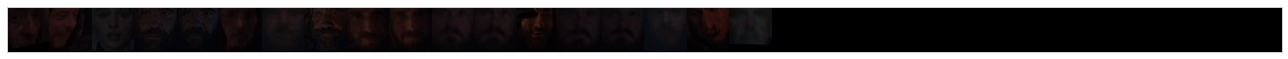

In [26]:
#@title Filter by face darkness. Threshold is of V (value) in HSV color-space.
darknessThreshold = 20 #@param {type:"number"}

def tooDark(face, threshold):
  hsvImage = mpl.colors.rgb_to_hsv(face.image)
  meanValue = np.mean(hsvImage[:,:,2])
  return meanValue < threshold

darkFaces = []
for face in allFaces:
  if tooDark(face, darknessThreshold):
    darkFaces.append(face)
    
print('%d of %d faces get filtered out for being too dark.' % (len(darkFaces), len(allFaces)))

showFaces(darkFaces)

74 of 1094 faces get filtered out for being too small.


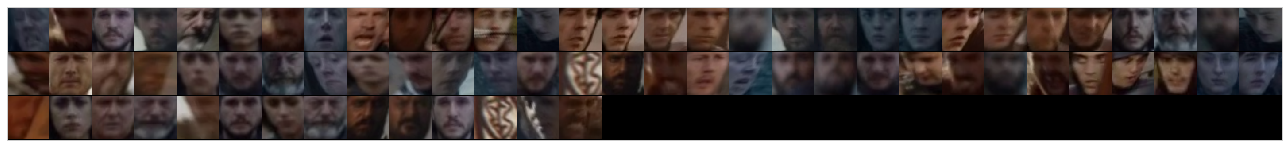

In [9]:
#@title Filter by face size. Threshold is width/height in pixels.
sizeThreshold = 37 #@param {type:"number"}

def tooSmall(face, threshold):
  br = face.bbBottomRight
  tl = face.bbTopLeft
  
  height = br[1] - tl[1]
  width = br[0] - tl[0]
  return height < threshold or width < threshold

smallFaces = []
for face in allFaces:
  if tooSmall(face, sizeThreshold):
    smallFaces.append(face)
    
print('%d of %d faces get filtered out for being too small.' % (len(smallFaces), len(allFaces)))

showFaces(smallFaces)

Size seems to be a bad filtering metric, so I will ommit from later filtering steps.

86 of 795 faces get filtered out for being too blurry.


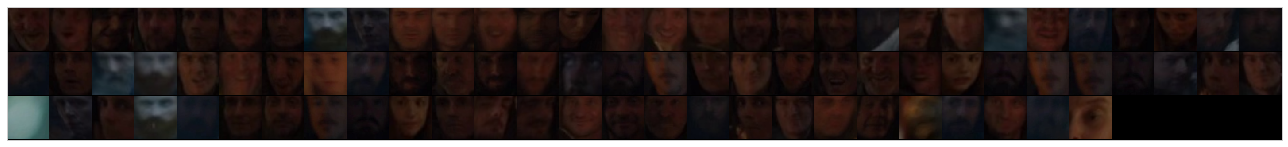

In [27]:
#@title Filter by face blurriness. Threshold is standard deviation of Laplacian.
blurrinessThreshold = 0.006 #@param {type:"number"}

def tooBlurry(face, threshold):
  im = face.image
  im = skimage.color.rgb2gray(im)
  L = scipy.ndimage.filters.laplace(im)
  std = np.std(L)
  
  return std < threshold

blurryFaces = []
for face in allFaces:
  if tooBlurry(face, blurrinessThreshold):
    blurryFaces.append(face)
    
print('%d of %d faces get filtered out for being too blurry.' % (len(blurryFaces), len(allFaces)))

showFaces(blurryFaces)

Characters Tweeted about for following image:
Peytr Baelish	3
Grey Worm	3
Cersei Lannister	3
Bronn	2
Daenerys Targaryen	1
Arya Stark	1
Olenna Tyrell	1


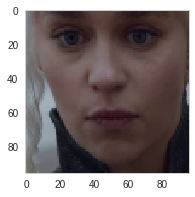

Characters Tweeted about for following image:
Peytr Baelish	3
Grey Worm	3
Cersei Lannister	3
Bronn	2
Daenerys Targaryen	1
Arya Stark	1
Olenna Tyrell	1


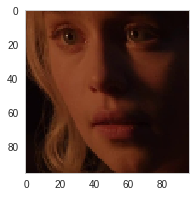

In [11]:
#@title For a random selection of faces, shows which characters were discussed in the specified interval after the face appeared.
minutes = 3 #@param {type:"slider", min:0, max:10, step:1}
numFacesToShow = 2 #@param {type:"slider", min:1, max:10, step:1}
randomSeed = 6543210 #@param {type:"integer"}

temp_fig_size = [3, 3]
plt.rcParams["figure.figsize"] = temp_fig_size

random.seed(randomSeed)

filteredFaces = list(set(allFaces) - set(blurryFaces) - set(darkFaces))

for idx in range(numFacesToShow):
  face = random.choice(filteredFaces)
  
  faceTime = face.getTime(cutsForEp)
  charactersForFace = utils.charactersAtTimeT(faceTime, charactersForEp, minutes*60.)
  charactersForFace = sorted(charactersForFace, key=lambda x: x[1], reverse=True)
  face.characters = charactersForFace

  print('Characters Tweeted about for following image:')
  for char_count in face.characters:
    print('%s\t%d' % char_count)
  plt.imshow(face.image)
  plt.show()

plt.rcParams["figure.figsize"] = fig_size


# Clustering

In the previous section we visualized the results for filtering on the faces for a single episode. In this next section, we peform filtering on all the episodes using the thresholds chosen in the previous section.

(You'll need to run the code from the previous section for this section to run successfully)

## Clustering Methods I've Impemented

### K-Means
This is standard k-means from sklearn.  It takes as input the number of clusters, k. Qualitatively, it does pretty badly.
### Modifed K-Means (Berg2004)
This is my implementation of the algorithm in [this](http://acberg.com/papers/berg_names_and_faces.pdf) paper.
It **automatically** computes the number of clusters from the number of characters associated with the faces.

The steps are as follows: 
1. Randomly assign each image to one of its extracted names
2. For each distinct name (cluster), calculate the mean of image vectors assigned to that name.
3. Reassign each image to the closest mean of its extracted names.
4. Repeat 2-3 until convergence (i.e. no image changes names during an iteration)

The paper also has some additional post-clustering pruning steps which I have not implemented.
### Spectral
This is the standard spectral clustering in sklearn. It takes as input the number of clusters, k. I am currently using an RBF kernel with the default settings for the similarity matrix. I have not tried playing around with the kernel.
### Sparsified Spectral
This is the standard spectral clustering in sklearn, except that I modify the similarit matrix to make it more sparse. My original idea was to remove the edge between two faces if the size of the intersection of the character lists associated with each face was 0. However, this method ends up removing 0 faces.

Instead, I keep only edges for which some character is associated with both of the faces, and for each of the two faces, that character's tweet frequency in the time interval following the face's timestamp is larger than the median tweet frequency over for that character over all episodes.

I don't know if median is the optimal threshold to use; I need to conduct more experiments on this. Mean is most defnitely bad because the distribution is very not normal.

### Agglomerative
This is the standard agglomerative clustering in sklearn. 


In [38]:
#@title Loads all of the face and character data into memory.
args = {'inputFaceFiles': 'face_data_paths.tsv',
        'method': 'berg2004',
        'tweetTimeWindow': 1,
        'blurrinessThreshold' : blurrinessThreshold,
        'darknessThreshold' : darknessThreshold,
        'sizeThreshold' : None, # This does not seem to be that effect so commenting out
        'saveClusterImages': False,
       }
args = namedtuple('Args', args.keys())(*args.values())

allFaces = cluster_all.readInFaces(args)

> /content/weakvideo/code/cluster_all.py(93)readInFaces()
-> with open(args.inputFaceFiles, 'r') as f:
(Pdb) n
> /content/weakvideo/code/cluster_all.py(94)readInFaces()
-> f.readline()
(Pdb) 
> /content/weakvideo/code/cluster_all.py(95)readInFaces()
-> for line in f:
(Pdb) 
> /content/weakvideo/code/cluster_all.py(96)readInFaces()
-> name, offset, faceFile, charactersFile, cutsFile= line.strip().split('\t')
(Pdb) 
> /content/weakvideo/code/cluster_all.py(97)readInFaces()
-> offset = float(offset)
(Pdb) 
> /content/weakvideo/code/cluster_all.py(98)readInFaces()
-> print('Reading in faces for %s...' %(name))
(Pdb) l
 93  	    with open(args.inputFaceFiles, 'r') as f:
 94  	        f.readline()
 95  	        for line in f:
 96  	            name, offset, faceFile, charactersFile, cutsFile= line.strip().split('\t')
 97  	            offset = float(offset)
 98  ->	            print('Reading in faces for %s...' %(name))
 99  	
100  	            charactersForEp = utils.processCharactersFile(c

107  	                allFaces.extend(faceList)
108  	                for face in faceList:
109  	                    face.time = face.getTime(cutsForEp)
110  	                    charactersForFace = utils.charactersAtTimeT(
111  	                        face.time, charactersForEp, 60.*args.tweetTimeWindow)
112  ->	                    face.characters = charactersForFace
113  	
114  	    print('Founds %d faces total' % len(allFaces))
115  	    badFaceFn = lambda f: f.tooBlurry(args.blurrinessThreshold) or f.tooSmall(args.sizeThreshold) or f.tooDark(args.darknessThreshold)
116  	    allFaces = list(face for face in allFaces if not badFaceFn(face))
117  	    print('Filtered out bad faces. %d faces remaning.' % (len(allFaces)))
(Pdb) n
> /content/weakvideo/code/cluster_all.py(108)readInFaces()
-> for face in faceList:
(Pdb) p face.characters
[('Aerys Targaryen', 2), ('Brienne of Tarth', 10), ('Samwell Tarly', 10), ('Ned Stark', 2), ('Daenerys Targaryen', 4), ('Peytr Baelish', 4), ('Walder 

### Run the following two code sections to qualitatively evaluate a clustering method of your choice.

In [0]:
#@title Pefform clustering on all the faces from all the episodes.
method = 'sparseSpectral' #@param ["berg2004", "kmeans", "spectral", "sparseSpectral", "agglomerative"] {type:"string"}
numClusters = 30 #@param {type:"integer"}

args = {'inputFaceFiles': 'face_data_paths.tsv',
        'numClusters': numClusters, # Not relevant for berg2004 or agglomerative methods
        'method': 'spectralSparse',
        'tweetTimeWindow': 3,
        'groundTruthPath': 'groundtruth.tsv',
        'saveClusterImages': False,
        'allFaces': allFaces
       }
args = namedtuple('Args', args.keys())(*args.values())

import pdb; pdb.set_trace()
clusters = cluster_all.main(args)

--Return--
> <ipython-input-52-bc13ff5fa495>(14)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) l
  9  	        'saveClusterImages': False,
 10  	        'allFaces': allFaces
 11  	       }
 12  	args = namedtuple('Args', args.keys())(*args.values())
 13  	
 14  ->	import pdb; pdb.set_trace()
 15  	clusters = cluster_all.main(args)
[EOF]
(Pdb) s
> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2885)run_code()
-> sys.excepthook = old_excepthook
(Pdb) s
> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2901)run_code()
-> outflag = 0
(Pdb) n
> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2902)run_code()
-> return outflag
(Pdb) n
--Return--
> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2902)run_code()->0
-> return outflag
(Pdb) n
> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2819)run_ast_nodes()
-> for i, node in enumerate(to_run_exec):
(Pdb) n
> /usr/lo

Exception: ignored

> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2823)run_ast_nodes()
-> return True
(Pdb) 
--Return--
> /usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py(2823)run_ast_nodes()->True
-> return True


In [0]:
#@title Displays the faces in the specified cluster.
character = 'Cersei Lannister' #@param ["Aerys Targaryen", "Archmaester Ebrose", "Arya Stark", "Benjen Stark", "Beric", "Bran Stark", "Brienne of Tarth", "Bronn", "Catelyn Stark", "Cersei Lannister", "Daario Naharis", "Daenerys Targaryen", "Ed Sheeran", "Ellaria Sand", "Euron Greyjoy", "Gendry", "Gilly", "Grand Maester Pycelle", "Grey Worm", "Hodor", "Hot Pie", "House frey", "Irri", "Jaime Lannister", "Joer Mormont", "Joffrey Baratheon", "Jojen Reed", "Jon Snow", "Jorah Mormont", "Lady Mormont", "Lysa Arryn", "Meera Reed", "Melisandre", "Missandei", "Myrcella Baratheon", "Ned Stark", "Night king", "Oberyn Martell", "Olenna Tyrell", "Olly", "Peytr Baelish", "Podrick", "Qyburn", "Ramsay Bolton", "Renly Baratheon", "Rhaegar Targaryen", "Rickon Stark", "Robb Stark", "Robert Baratheon", "Roose Bolton", "Samwell Tarly", "Sansa Stark", "Ser Davos", "Stannis Baratheon", "the hound", "the mountain", "Theon Greyjoy", "Thoros", "Tommen Baratheon", "Tormund", "Tycho Nestoris", "Tyene", "Tyrion Lannister", "Tywin Lannister", "Varys", "Walder Frey", "Yara Greyjoy"] {type:"string"}


--2018-05-21 19:07:16--  http://www.seas.upenn.edu/~daphnei/GoT/groundtruth.tsv
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101189 (99K) [text/tab-separated-values]
Saving to: ‘groundtruth.tsv’

groundtruth.tsv     100%[===================>]  98.82K   483KB/s    in 0.2s    

2018-05-21 19:07:16 (483 KB/s) - ‘groundtruth.tsv’ saved [101189/101189]

